# Section IV. ML-model

### Load libraries, functions, palette, theme, etc.

In [462]:
# load libraries
%run __theme.ipynb

In [463]:
# load functions
%run __functions.ipynb

In [464]:
# start stopwatch
start = stopwatch_start()

In [465]:
dir_current = '04-ml-model'

In [466]:
dir_save_files = 'files/'

In [467]:
dir_load_files = 'files/'

In [468]:
dir_save_img = 'docs/img/'

In [469]:
session_name = dir_current

### Load libraries, functions, palette, theme

In [470]:
import os
from pathlib import Path

In [471]:
# load functions
from __functions import *

In [472]:
# load libraries and palette
%run __libraries.ipynb

In [473]:
# start stopwatch
start = stopwatch_start()

### Variables

In [474]:
dir_current = '04-ml-model'

In [475]:
dir_save_files = 'files/'

In [476]:
dir_load_files = 'files/'

In [477]:
dir_save_img = 'docs/img/'

### Load Files

##### Dictionaries

In [478]:
datasets = loadit('datasets', path=dir_load_files)

In [479]:
variables = loadit('variables', path=dir_load_files, create_empty_dict=True)

In [480]:
cv = loadit('cv', path=dir_load_files, create_empty_dict=True)

##### Datasets

In [481]:
train = extract_variable('train_preprocessed', datasets)

In [482]:
valid = extract_variable('valid_preprocessed', datasets)

In [483]:
test = extract_variable('test_preprocessed', datasets)

Variable test_preprocessed not found


##### CV results

In [484]:
cv0 = extract_variable('cv0', cv)

In [485]:
cv1 = extract_variable('cv1', cv)

In [486]:
cv2 = extract_variable('cv2', cv)

In [487]:
cv3 = extract_variable('cv3', cv)

## Base ML-model

### Datasets and Variables

In [488]:
features = [
    'temperature', 'humidity', 'windspeed', 'generaldiffuseflows',
    'diffuseflows', 'minute', 'hour', 'day',
    'day_number', 'day_of_year', 'weekday', 'week', 'month',
    'target_diff', 'target_returns',
    'target_volatility', 'p', 'minute_of_day', 'is_Friday', 'is_Sunday',
    'diff_Sunday', 'is_Day', 'is_31', 'is_20hours', 'target_previous_month'
]

In [489]:
target = train['target'].copy()

In [490]:
train_ml = train[features].copy()

In [491]:
train_ml = train_ml.reset_index(names='datetime')

In [492]:
test_df = train_ml.copy()

In [493]:
cv_indexes_train, cv_indexes_eval = cv_split_indexes(
    data=train['target'], start='2017-03-01', train_size=1,
    test_size=1, size_unit='months', n_splits=5, freq='10min')

In [494]:
cv_indexes_gs_base = []
for trn, evl in zip(cv_indexes_train, cv_indexes_eval):
    trn_df = train_ml[train_ml['datetime'].isin(trn)].copy()
    trn_ev = train_ml[train_ml['datetime'].isin(evl)].copy()
    cv_indexes_gs_base.append((trn_df.index, trn_ev.index))

In [495]:
train_ml = train_ml.drop('datetime', axis=1)

In [496]:
train_ml.head()

,temperature,humidity,windspeed,generaldiffuseflows,diffuseflows,minute,hour,day,day_number,day_of_year,...,target_volatility,p,minute_of_day,is_Friday,is_Sunday,diff_Sunday,is_Day,is_31,is_20hours,target_previous_month
0,6.559,73.8,0.083,0.051,0.119,0,0,1,1,1,...,NaN,NaN,0,0,1,0.0,0,0,0,NaN
1,6.414,74.5,0.083,0.070,0.085,10,0,1,1,1,...,0.015508,-0.124532,10,0,1,0.0,0,0,0,NaN
2,6.313,74.5,0.080,0.062,0.100,20,0,1,1,1,...,0.000530,-0.023028,20,0,1,0.0,0,0,0,NaN
3,6.121,75.0,0.083,0.091,0.096,30,0,1,1,1,...,0.000953,-0.030872,30,0,1,0.0,0,0,0,NaN
4,5.921,75.7,0.081,0.048,0.085,40,0,1,1,1,...,0.001001,-0.031640,40,0,1,0.0,0,0,0,NaN


### Model

In [497]:
lgb_base = LGBMRegressor()

In [498]:
params_base = {
    'n_estimators': [50, 75, 100, 150],
    'max_depth': [3, 6, 9, 12, 24, 48],
    'learning_rate': [0.1, 0.3],
    'random_state': [seed],
    'verbose': [-1]
}

In [499]:
gs_base = GridSearchCV(
    estimator=lgb_base,
    param_grid=params_base,
    scoring='neg_root_mean_squared_error',
    cv=cv_indexes_gs_base
)

In [500]:
start_gs_base = stopwatch_start()
gs_base.fit(train_ml, target)
stopwatch_stop(start_gs_base)

Execution time: 0:00:37


In [501]:
gs_base.best_estimator_

LGBMRegressor(max_depth=3, n_estimators=150, random_state=42, verbose=-1)

In [502]:
gs_base.best_score_

-3379.674885860381

In [503]:
gs_base_best_results = pd.DataFrame(gs_base.cv_results_).sort_values('rank_test_score').iloc[0]

In [504]:
gs_base_best_results_splits_iloc = \
    list(np.where(pd.Series(gs_base_best_results.index).str.contains('split'))[0])

In [505]:
gs_base_best_results_splits = gs_base_best_results.T.iloc[gs_base_best_results_splits_iloc]

In [506]:
gs_base_best_results_splits = gs_base_best_results_splits.abs()

In [507]:
gs_base_best_results_splits

split0_test_score     1803.07712
split1_test_score     2007.49335
split2_test_score    2877.777065
split3_test_score    5356.669385
split4_test_score    4853.357509
Name: 3, dtype: object

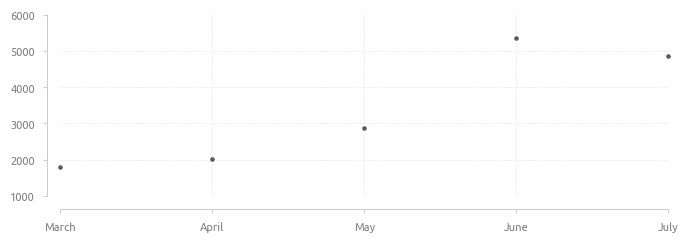

In [508]:
plt.scatter(
    x=gs_base_best_results_splits.index,
    y=gs_base_best_results_splits.values, s=75)
plt.xticks(gs_base_best_results_splits.index, months_list[2:7])
axis_rstyle(yticks=[1000, 6000, 1000], grid=True)

In [509]:
feature_importance = pd.DataFrame({
    'Feature': gs_base.best_estimator_.feature_name_,
    'Importance': gs_base.best_estimator_.feature_importances_
})
feature_importance.sort_values('Importance', ascending=False, inplace=True)

In [510]:
data_plot = feature_importance.loc[feature_importance['Importance']>0,:]
data_plot = data_plot.sort_values('Importance', ascending=False)

In [511]:
data_plot.head()

,Feature,Importance
17,minute_of_day,257
8,day_number,229
24,target_previous_month,122
13,target_diff,72
10,weekday,45


In [512]:
values = data_plot['Importance'][:10]
labels = data_plot['Feature'][:10]

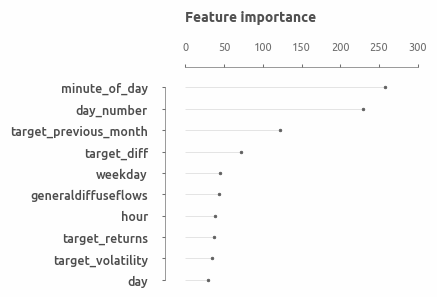

In [513]:
fig = plot_bar_horizontal(
    values=values,
    labels=labels,
    labelsize=9,
    labelcolor='0.3',
    labelweight='medium',
    figsize=(3, 2.5),
    kind='lol',
    width=0.5,
    s=15,
    x_lim_right=300
)
# savefig('feature_importance', save_img)

## ML-model enhancement

## Save Data

### Execution time

In [516]:
stopwatch_stop(start)

Execution time: 0:00:38
